<a href="https://colab.research.google.com/github/larissamacb/7DaysOfCode-Linkedin/blob/main/fake%26true_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.figure_factory as ff
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
fake_df = pd.read_csv('/content/Fake.csv')
true_df = pd.read_csv('/content/True.csv')

In [ ]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Verificação dos dados:

*   Dados duplicados
*   Valores nulos
*   Colunas compatíveis

In [ ]:
true_df.duplicated().sum()

np.int64(206)

In [ ]:
fake_df.duplicated().sum()

np.int64(3)

In [ ]:
true_df.isnull().sum()

,0
title,0
text,0
subject,0
date,0


In [ ]:
fake_df.isnull().sum()

,0
title,0
text,0
subject,0
date,0


In [ ]:
# Nenhum valor nulo, mas há duplicatas nos dois arquivos

true_df.drop_duplicates(inplace=True)
fake_df.drop_duplicates(inplace=True)

In [ ]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21211 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21211 non-null  object
 1   text     21211 non-null  object
 2   subject  21211 non-null  object
 3   date     21211 non-null  object
dtypes: object(4)
memory usage: 828.6+ KB


In [ ]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23478 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23478 non-null  object
 1   text     23478 non-null  object
 2   subject  23478 non-null  object
 3   date     23478 non-null  object
dtypes: object(4)
memory usage: 917.1+ KB


Junta os dois dataframes em um só, adicionando uma nova coluna 'label' para ser justamente a classificação das notícias

In [ ]:
# adiciona uma coluna chamada 'label' no true e define todas as linhas dessa coluna como 1, indicando que essas notícias são verdadeiras
# no fake, adiciona a mesma coluna, mas indicando todas as colunas como 0 (false)

true_df['label'] = 1
fake_df['label'] = 0

In [ ]:
# concatena os dois dataframes em um único chamado news, com notícias falsas e verdadeiras agora diferenciadas pela coluna 'label'.

news = pd.concat([true_df, fake_df])
news

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [ ]:
# reseta os indexes, "recolocando" eles, já que a concatenação pode ter os desorganizado

news.reset_index(inplace=True)

In [ ]:
# elimina as colunas exceto por text
# a coluna index não existia, mas passou a existir por causa do reset_index

news.drop(columns=['index', 'title', 'subject', 'date'], inplace=True)

In [ ]:
# antes os índices estavam errados; eram 44689 rows e 23480 era o último index
# agora os indexes vão corretamente até 44688

news

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...
44684,21st Century Wire says As 21WIRE reported earl...,0
44685,21st Century Wire says It s a familiar theme. ...,0
44686,Patrick Henningsen 21st Century WireRemember ...,0
44687,21st Century Wire says Al Jazeera America will...,0


In [ ]:
# criando uma cópia de news

df = news.copy()
df

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...
44684,21st Century Wire says As 21WIRE reported earl...,0
44685,21st Century Wire says It s a familiar theme. ...,0
44686,Patrick Henningsen 21st Century WireRemember ...,0
44687,21st Century Wire says Al Jazeera America will...,0


In [ ]:
# regex criado para identificar urls
# novo dataframe criado para guardar textos que contém urls

url = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F] [0-9a-fA-F]))+'
comment_with_url=df[df['text'].str.contains(url,regex=True)]
comment_with_url

,text,label
21213,"On Friday, it was revealed that former Milwauk...",0
21214,"On Christmas day, Donald Trump announced that ...",0
21227,A new animatronic figure in the Hall of Presid...,0
21230,Senate Majority Whip John Cornyn (R-TX) though...,0
21238,Judge Jeanine Pirro has continued her scream...,0
...,...,...
44634,21st Century Wire says This latest bombshell r...,0
44648,21st Century Wire says One TV personality Tru...,0
44671,Patrick Henningsen 21st Century Wire UPDATE: 1...,0
44673,21st Century Wire says Various parties in Wash...,0


In [ ]:
df['text'][21213]

'On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he later had detained by the police for no reason whatsoever, except that maybe his feelings were hurt. Clarke messaged the police to stop Black after he deplaned, and now, a search warrant has been executed by the FBI to see the exchanges.Clarke is calling it fake news even though copies of the search warrant are on the Internet. I am UNINTIMIDATED by lib media attempts to smear and discredit me with their FAKE NEWS reports designed to silence me,  the former sheriff tweeted.  I will continue to poke them in the eye with a sharp stick and bitch slap these scum bags til they get it. I have been attacked by better people than them #MAGA I am UNINTIMIDATED by lib media attempts to smear and discredi

In [ ]:
# no dataframe original, remove tudo que é identificado como uma url

df['text'].replace(url,' ',regex=True,inplace=True)

In [ ]:
# função de preprocessamento que:

def preprocess_text(text):
    text = text.lower() # deixa o texto em palavras minúsculas, "notícia" e "Notícia" serão a mesma coisa
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove urls genéricas
    text = re.sub(r'<.*?>+', '', text) # remove tags html
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # remove pontuações
    text = re.sub(r'\n', '', text) # remove quebras de linha
    text = re.sub(r'\w*\d\w*', '', text) # remove palavras com número
    return text

In [ ]:
# aplica a função a todas as linhas do dataframe usando o método .apply()
# o lambda é uma forma de passar cada valor da coluna para a função.

df['text']=df['text'].apply(lambda x:preprocess_text(x))

# Método .apply() e a função lambda


*   O método .apply() é uma função do pandas que permite aplicar uma função em cada elemento de uma coluna ou linha de um DataFrame ou Series.
*   Quando você usa o .apply() em uma coluna de um DataFrame (no seu caso, df['text']), ele passa cada valor da coluna como argumento para a função que você fornecer. O x que aparece na função lambda é cada valor individual da coluna 'text'. Isso significa que para cada linha no DataFrame, o valor da coluna 'text' correspondente a essa linha será passado como o argumento x na função lambda.
*   Exemplo de uso da função lambda:

```
somar_2 = lambda x: x + 2
print(somar_2(3))  # Saída: 5
```

*   lambda é uma forma de criar funções pequenas e anônimas.
*   As funções lambda são muito usadas quando você precisa de uma função simples, especialmente como argumento para outras funções (como .apply() no pandas).

In [ ]:
df['text'][324]

'reuters  us president donald trump continued to dominate twitter in  even though former president barack obama’s tweets were more liked and both were blown away by one man’s quest for free chicken nuggets twitter revealed the year’s most liked and retweeted tweets on tuesday reflecting how a nation bitterly divided between republicans and democrats is likewise split on social media trump whose  million followers of realdonaldtrump rank him  on twitter was the most tweeted about world leader and us elected official  likewise foxnews the conservative cable news channel was the top tweeted news outlet led by seanhannity the host who is a friend and ally of the president obama was also wellrepresented the former president whose barackobama ranked as the thirdmostfollowed twitter account behind katyperry and justinbieber posted the most popular tweet nearly  million likes for the nelson mandela quote “no one is born hating another person because of the color of his skin or his background o

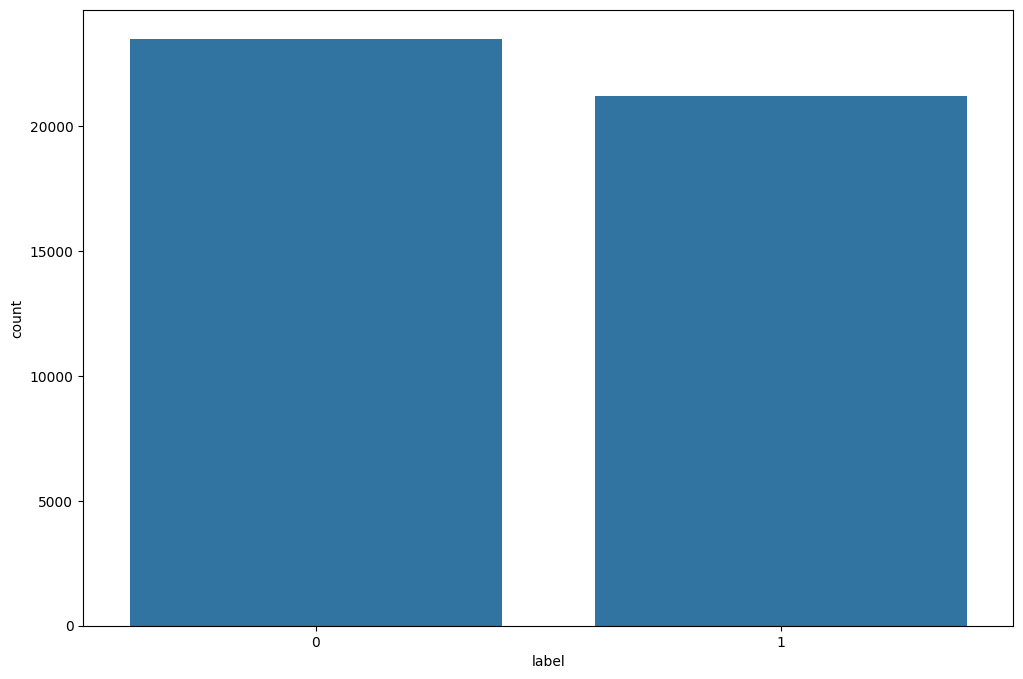

In [ ]:
# gráfico com notícias falsas X verdadeiras

plt.figure(figsize=(12,8))
sns.countplot(data=df,x='label')
plt.show()

In [ ]:
# cria uma nova coluna para a contagem de palavras
# na coluna texto, aplica uma função lambda que, para cada valor (texto na coluna text), usa split(), uma função que separa palavras de uma string, usando espaços em branco (por padrão) para fazer a divisão
#  usando espaços em branco (por padrão) para fazer a divisão e calcula o tamanho do resultaso (um array) para jogar a quantidade de palavras na coluna criada

df['word_count']=df['text'].apply(lambda x: len(x.split()))

<Figure size 1200x800 with 0 Axes>

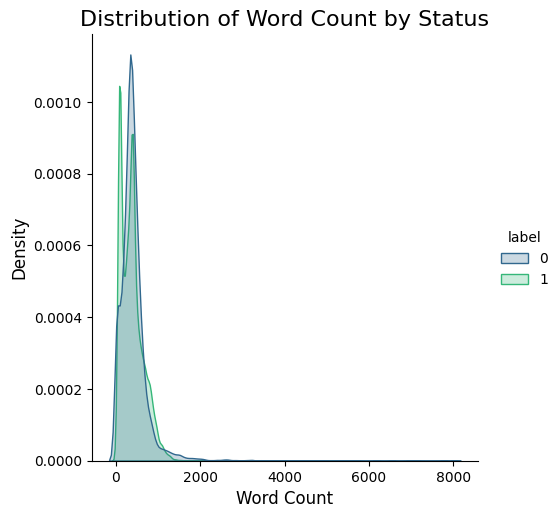

In [ ]:
# cria uma nova figura do matplotlib de 12x8 polegadas
plt.figure(figsize=(12, 8))

# displot = distribution plot. Ele pode criar histogramas e gráficos de densidade (KDE - Kernel Density Estimation)
#para mostrar como os valores de uma variável estão distribuídos.
sns.displot(data=df, x='word_count', hue='label', kind='kde', fill=True, palette='viridis')
plt.title('Distribution of Word Count by Status', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

In [ ]:
# cria um set usando as stopwords em inglês do nltk (foi importado no primeiro bloco usando
# "from nltk.corpus import stopwords" e "nltk.download('stopwords')"
stop_words = set(stopwords.words('english'))

# cria uma nova coluna com o número de stop words
df['num_stop_words']=df['text'].apply(lambda x: len([word for word in x.split() if word in stop_words]))

# [word for word in x.split() if word in stop_words] -> cria um array usando um loop que
# adiciona a *palavra* a cada *palavra* no array criado pelo split se a *palavra* for uma stopword

# Revisão sobre o Set

1.   Não mantém a ordem da inserção de dados
1.   Não pode ser modificado
2.   Contém dados de todos os tipos
2.   Não permite itens duplicados

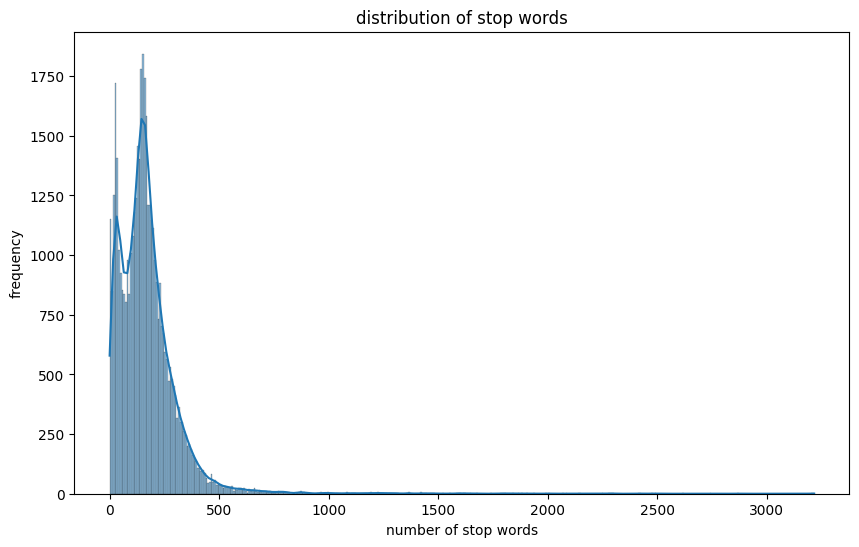

In [ ]:
# plota a distirbuição de stop words

plt.figure(figsize=(10,6))

sns.histplot(df['num_stop_words'],kde=True)
plt.title('distribution of stop words')
plt.xlabel('number of stop words')
plt.ylabel('frequency')
plt.show()

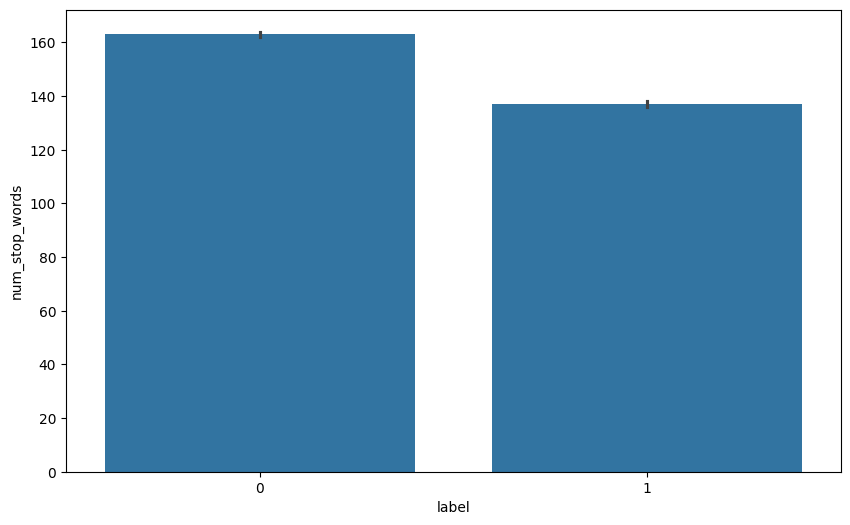

In [ ]:
# plota um gráfico de barras com base na mediana do número de stop words das notícias falsas e das verdadeiras

plt.figure(figsize=(10,6))
sns.barplot(data=df,x='label',y='num_stop_words',estimator=np.median)
plt.show()

In [ ]:
# o Counter é uma estrutura de dados especializada em contar elementos e gerar contagens de frequência
from collections import Counter

# itera por cada campo da coluna 'text' atribuindo a eles o nome 'comment'
# em cada iteração, usa .split() no 'comment' e atribui a cada parte splitada o nome 'word'
# itera por cada uma dessas 'word', e se ela estiver entre as stop_words, adiciona ao array all_stop_words
all_stop_words = [word for comment in df['text'] for word in comment.split() if word in stop_words]

# cria um objeto Counter que conta a quantidade de vezes que cada elemento em all_stop_words aparece
# retorna as 25 mais comuns
most_common_stop_words = Counter(all_stop_words).most_common(25)

# cria um dataframe do pandas convertendo a 'most_common_stop_words' que criamos e definindo as colunas
# isso porque originalmente ele é criado como um array (demonstração de como fica no próximo bloco)
top_25_df = pd.DataFrame(most_common_stop_words,columns=['stopword','count'])
top_25_df.head()

,stopword,count
0,the,998985
1,to,531318
2,of,438160
3,a,404618
4,and,403456


In [ ]:
most_common_stop_words

[('the', 998985),
 ('to', 531318),
 ('of', 438160),
 ('a', 404618),
 ('and', 403456),
 ('in', 342069),
 ('that', 235174),
 ('on', 187926),
 ('s', 173431),
 ('for', 170495),
 ('is', 165202),
 ('he', 129252),
 ('it', 122448),
 ('with', 116526),
 ('was', 114957),
 ('as', 102061),
 ('his', 95465),
 ('by', 94353),
 ('has', 87790),
 ('be', 82298),
 ('have', 81912),
 ('not', 80297),
 ('from', 79469),
 ('this', 74101),
 ('at', 73906)]

# Sobre a criação de arrays e estruturas resumidas

A linha de código abaixo parece confusa, mas é como uma estrutura normal resumida para montar um array em menos linhas.

```
all_stop_words = [word for comment in df['text'] for word in comment.split() if word in stop_words]
```

O segredo é separar pelas palavras-chave de estrutura (if, for) e jogar a primeira palavra (word) lá pra baixo. Como ele seria se não fosse resumido:


```
for comment in df['text']:
     for word in comment.split():
         if word in stop_words:
             all_stop_words.add(word)
```





<ipython-input-36-61a66c88a5fa>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_df,y='stopword',x='count',palette='viridis')


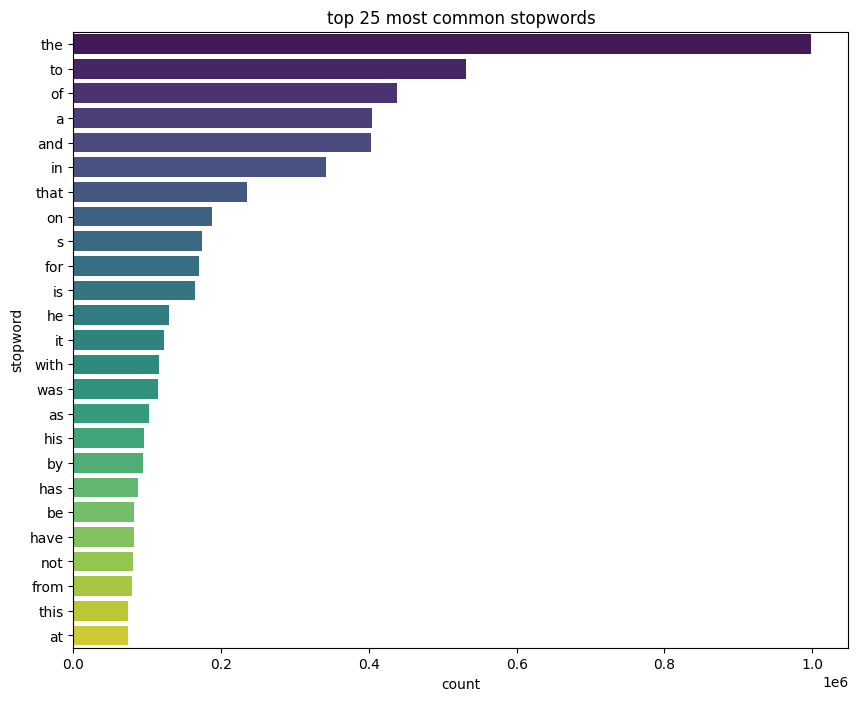

In [ ]:
# plota um gráfico com as stop words que mais aparecem

plt.figure(figsize=(10,8))
sns.barplot(data=top_25_df,y='stopword',x='count',palette='viridis')
plt.title('top 25 most common stopwords')
plt.xlabel('count')
plt.ylabel('stopword')
plt.show()

In [ ]:
# importa a biblioteca que faz nuvem de palavras
from wordcloud import WordCloud

# cria uma função para receber um texto e plotar a nuvem de palavras
def plot_word_count(text):

  # wordcloud = WordCloud().generate(text); ' '.join(text) -> se text for uma lista de palavras ou frases,
  # esse comando junta tudo em uma única string separada por espaços.
  wordcloud = WordCloud(width=800,height=400,background_color='white').generate(' '.join(text))
  plt.figure(figsize=(10,5))

  # interpolation='bilinear' suaviza a imagem para evitar "pixelização".
  plt.imshow(wordcloud,interpolation='bilinear')
  plt.axis('off')
  plt.show()

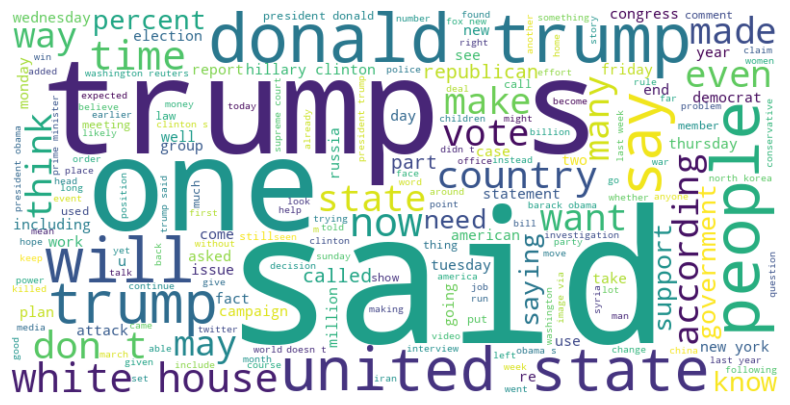

In [ ]:
# Como text é um array de frases, o ' '.join(text) juntou todas as frases em uma única string, separando-as por espaços

plot_word_count(df['text'])

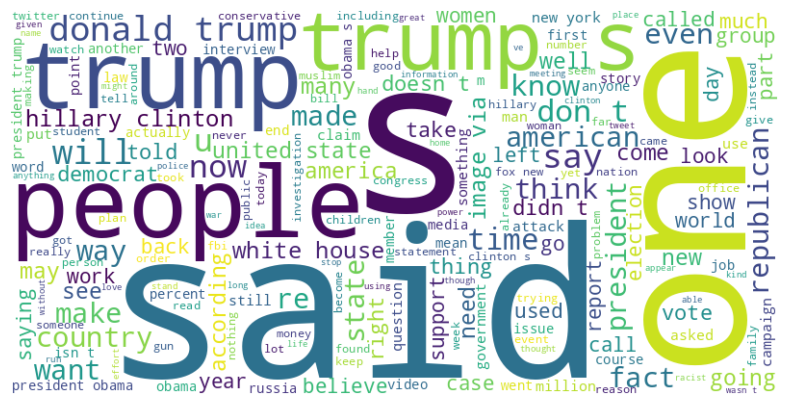

In [ ]:
# plota as palavras só dos registros de fake news

plot_word_count(df[df['label']==0]['text'])

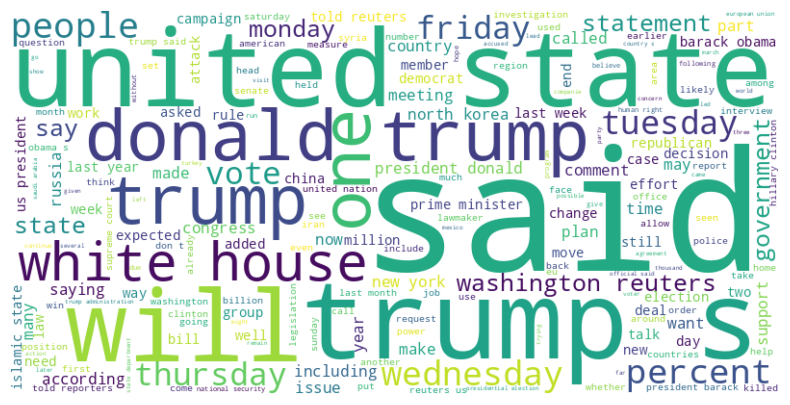

In [ ]:
# plota as palavras só dos registros de true news

plot_word_count(df[df['label']==1]['text'])

In [ ]:
# começa a separar para treino e testes

x = df['text']
y = df['label']

In [ ]:
df['text'][0]

'washington reuters  the head of a conservative republican faction in the us congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a “fiscal conservative” on sunday and urged budget restraint in  in keeping with a sharp pivot under way among republicans us representative mark meadows speaking on cbs’ “face the nation” drew a hard line on federal spending which lawmakers are bracing to do battle over in january when they return from the holidays on wednesday lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues such as immigration policy even as the november congressional election campaigns approach in which republicans will seek to keep control of congress president donald trump and his republicans want a big budget increase in military spending while democrats also want proportional increases for nondefense “discretionary” spending on programs that support education scientific research i

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

In [ ]:
# TfidfVectorizer() é um método do Scikit-Learn (sklearn.feature_extraction.text)
# ele transforma textos em vetores numéricos com base na frequência das palavras ajustada pela sua importância
# palavras muito comuns em todos os textos terão menos peso, enquanto palavras específicas terão mais peso
tfidf = TfidfVectorizer()

# fit() analisa o texto e aprende quais palavras existem e como calcular os pesos TF-IDF para cada uma
# transform() aplica essa transformação, convertendo x_train em uma matriz numérica
x_train_vec = tfidf.fit_transform(x_train)

# somente transform(), sem fit(), porque queremos aplicar o mesmo vocabulário aprendido nos dados de treino
# isso garante que os vetores de teste usem a mesma estrutura de palavras que os de treino
x_test_vec = tfidf.transform(x_test)

In [ ]:
lr = LogisticRegression()

# treina
lr.fit(x_train_vec,y_train)

# faz a previsão
y_pred = lr.predict(x_test_vec)

print(f'accuracy Score is :',accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_fig = ff.create_annotated_heatmap (
    z = cm,
    x = list(set(y_test)),
    y = list(set(y_test)),
    annotation_text = cm,
    colorscale='Viridis'
)

cm_fig.update_layout(title='Confusion Matrix')
cm_fig.show()

accuracy Score is : 0.9860147684045648


# Matriz de Confusão

*   [[Falso positivo // Verdadeiro positivo]
*   [Verdadeiro negativo // Falso negativo]]

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(x_train_vec, y_train)
y_pred = dt.predict(x_test_vec)

print(f'accuracy Score is :', accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_fig = ff.create_annotated_heatmap(
    z=cm,
    x=list(set(y_test)),
    y=list(set(y_test)),
    annotation_text=cm,
    colorscale='Viridis'
)

cm_fig.update_layout(title='Confusion Matrix')
cm_fig.show()

accuracy Score is : 0.9960841351532781


# Resultados

Como dados de treino e teste apenas o texto da notícia sem pontuações e com minúsculas:
*   Regressão Logística: 0.9860147684045648
*   Árvore de Decisão: 0.9960841351532781




Autoral
# O que diferencia notícias falsas de verdadeiras?
Daqui para baixo o código será de minha autoria, porque quis entender melhor as diferenças entre os dois tipos de notícias que os modelos encontraram.

In [ ]:
# análise dos títulos das notícias falsas

for title in fake_df.iloc[:10]['title']:
    print(title + '\n')

 Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing

 Drunk Bragging Trump Staffer Started Russian Collusion Investigation

 Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’

 Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES)

 Pope Francis Just Called Out Donald Trump During His Christmas Speech

 Racist Alabama Cops Brutalize Black Boy While He Is In Handcuffs (GRAPHIC IMAGES)

 Fresh Off The Golf Course, Trump Lashes Out At FBI Deputy Director And James Comey

 Trump Said Some INSANELY Racist Stuff Inside The Oval Office, And Witnesses Back It Up

 Former CIA Director Slams Trump Over UN Bullying, Openly Suggests He’s Acting Like A Dictator (TWEET)

 WATCH: Brand-New Pro-Trump Ad Features So Much A** Kissing It Will Make You Sick



In [ ]:
# análise dos títulos das notícias verdadeiras

for title in true_df.iloc[:10]['title']:
    print(title + '\n')

As U.S. budget fight looms, Republicans flip their fiscal script

U.S. military to accept transgender recruits on Monday: Pentagon

Senior U.S. Republican senator: 'Let Mr. Mueller do his job'

FBI Russia probe helped by Australian diplomat tip-off: NYT

Trump wants Postal Service to charge 'much more' for Amazon shipments

White House, Congress prepare for talks on spending, immigration

Trump says Russia probe will be fair, but timeline unclear: NYT

Factbox: Trump on Twitter (Dec 29) - Approval rating, Amazon

Trump on Twitter (Dec 28) - Global Warming

Alabama official to certify Senator-elect Jones today despite challenge: CNN



In [ ]:
# criando um novo dataframe das duas que não foi modificado ainda
all_news = pd.concat([true_df, fake_df])
all_news.reset_index(drop=True, inplace=True)

# removendo a pontuação
all_news['title'] = all_news['title'].apply(lambda x: re.sub(r'[%s]' % re.escape(string.punctuation), '', x))

# criando uma função para contar o número de palavras em caixa alta em cada título
# ignora palavras com menos de 4 letras porque geralmente são entidades, como US, FBI e CNN
def count_caps_words(row):
    words = [word for word in row['title'].split() if word.isupper() and len(word) > 3]
    return len(words)

# cria uma nova coluna para guardar os resultados
all_news['caps_words'] = all_news.apply(count_caps_words, axis=1)

all_news.head()

,title,text,subject,date,label,caps_words
0,As US budget fight looms Republicans flip thei...,WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,0
1,US military to accept transgender recruits on ...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,0
2,Senior US Republican senator Let Mr Mueller do...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,0
4,Trump wants Postal Service to charge much more...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,0


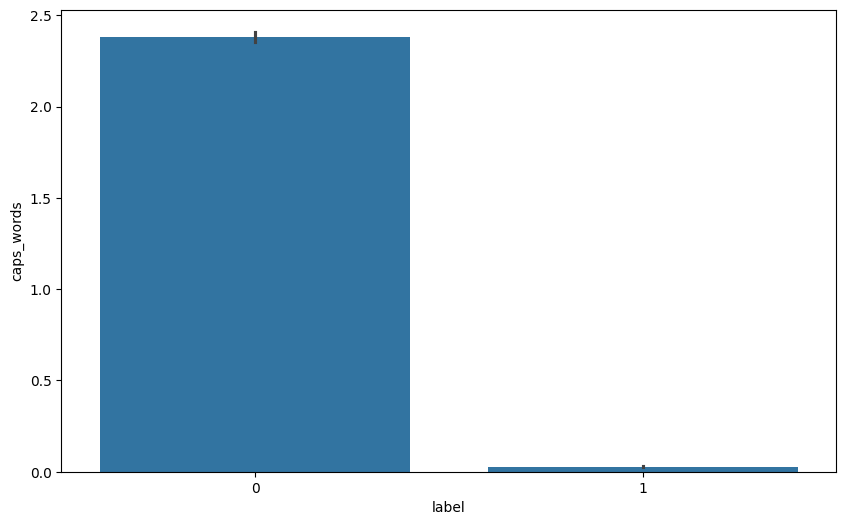

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=all_news,x='label',y='caps_words')
plt.show()

<Figure size 1200x800 with 0 Axes>

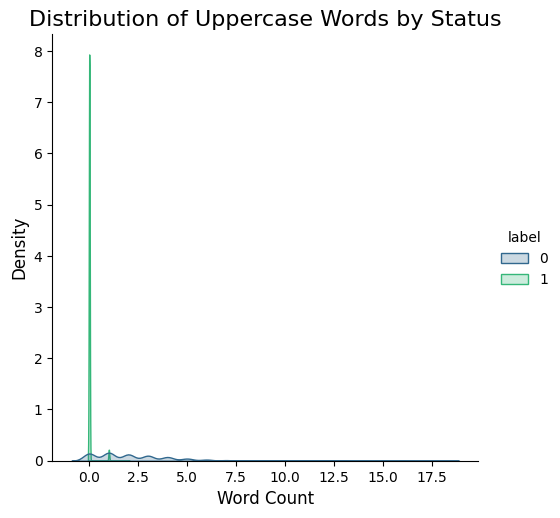

In [ ]:
# cria uma nova figura do matplotlib de 12x8 polegadas
plt.figure(figsize=(12, 8))

sns.displot(data=all_news, x='caps_words', hue='label', kind='kde', fill=True, palette='viridis')
plt.title('Distribution of Uppercase Words by Status', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

In [ ]:
# mesmos tratamentos do text do outro dataframe (df)
url = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F] [0-9a-fA-F]))+'
all_news['text'].replace(url,' ',regex=True,inplace=True)

def preprocess_text(text):
    text = text.lower() # deixa o texto em palavras minúsculas, "notícia" e "Notícia" serão a mesma coisa
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove urls genéricas
    text = re.sub(r'<.*?>+', '', text) # remove tags html
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # remove pontuações
    text = re.sub(r'\n', '', text) # remove quebras de linha
    text = re.sub(r'\w*\d\w*', '', text) # remove palavras com número
    return text

all_news['text']=all_news['text'].apply(lambda x:preprocess_text(x))
all_news['title']=all_news['title'].apply(lambda x:preprocess_text(x))

all_news.drop(columns=['subject', 'date'], inplace=True)

all_news

<ipython-input-56-95ed3285795f>:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,title,text,label,caps_words
0,as us budget fight looms republicans flip thei...,washington reuters the head of a conservative...,1,0
1,us military to accept transgender recruits on ...,washington reuters transgender people will be...,1,0
2,senior us republican senator let mr mueller do...,washington reuters the special counsel invest...,1,0
3,fbi russia probe helped by australian diplomat...,washington reuters trump campaign adviser geo...,1,0
4,trump wants postal service to charge much more...,seattlewashington reuters president donald tr...,1,0
...,...,...,...,...
44684,mcpain john mccain furious that iran treated u...,century wire says as reported earlier this w...,0,0
44685,justice yahoo settles email privacy classactio...,century wire says it s a familiar theme whene...,0,1
44686,sunnistan us and allied ‘safe zone’ plan to ta...,patrick henningsen century wireremember when...,0,0
44687,how to blow million al jazeera america finall...,century wire says al jazeera america will go ...,0,0


In [ ]:
all_news['text'] = all_news['title'] + " " + all_news['text']

x = all_news[['text', 'caps_words']]
y = all_news['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

tfidf = TfidfVectorizer()

x_train_vec = tfidf.fit_transform(x_train['text'])
x_test_vec = tfidf.transform(x_test['text'])

import scipy.sparse  # Para concatenar matriz esparsa com colunas numéricas

x_train_vec = scipy.sparse.hstack((x_train_vec, x_train[['caps_words']].values))
x_test_vec = scipy.sparse.hstack((x_test_vec, x_test[['caps_words']].values))


In [ ]:
x_train_vec

<COOrdinate sparse matrix of dtype 'float64'
	with 7430528 stored elements and shape (35751, 180434)>

In [ ]:
lr = LogisticRegression()

# treina
lr.fit(x_train_vec,y_train)

# faz a previsão
y_pred = lr.predict(x_test_vec)

print(f'accuracy Score is :',accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_fig = ff.create_annotated_heatmap (
    z = cm,
    x = list(set(y_test)),
    y = list(set(y_test)),
    annotation_text = cm,
    colorscale='Viridis'
)

cm_fig.update_layout(title='Confusion Matrix')
cm_fig.show()

accuracy Score is : 0.9912732154844485


In [ ]:
dt = DecisionTreeClassifier()
dt.fit(x_train_vec, y_train)
y_pred = dt.predict(x_test_vec)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt, x_train_vec, y_train, cv=3)

print(f'Average accuracy score: {scores.mean()}')

print(f'accuracy Score is :', accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_fig = ff.create_annotated_heatmap(
    z=cm,
    x=list(set(y_test)),
    y=list(set(y_test)),
    annotation_text=cm,
    colorscale='Viridis'
)

cm_fig.update_layout(title='Confusion Matrix')
cm_fig.show()

Average accuracy score: 0.9965875080417331
accuracy Score is : 0.9972029536809129


In [ ]:
x_test

,text,caps_words
17893,merkel juncker discuss catalan crisis eu offic...,0
39482,liberal hack katie couric says fake news is “t...,6
36273,trump was right audit reveals state dept cyber...,2
21761,clay aiken says he was a ‘fg dumbass’ for thi...,0
7557,us militia girds for trouble as presidential e...,0
...,...,...
16293,us has lost trust in south sudan trump envoy t...,0
27905,ted cruz doesn’t want transgender people to p...,1
13631,turkey says us wants use gold trader case to i...,0
33135,is obama punishing fiatchrysler for us jobs ...,3
